In [1]:
import sys
sys.path.append('..')

In [2]:
import io
import math
from pathlib import Path

import numpy as np
import cv2 as cv
import pytesseract
from PIL import Image as PImage, ImageDraw, ImageOps

import digi_leap.util as util

In [3]:
DATA_DIR = Path('..') / 'data'
MODEL_DIR = DATA_DIR / 'model'
LABEL_DIR = DATA_DIR / 'labels' / 'typewritten'

MODEL = MODEL_DIR / 'frozen_east_text_detection.pb'

In [4]:
IMAGES = sorted(LABEL_DIR.glob('*.jpg'))

In [5]:
IDX = 46
print(IMAGES[IDX])

../data/labels/typewritten/10667427.jpg


In [6]:
MIN_CONF = 0.5

In [7]:
image = cv.imread(str(IMAGES[IDX]))
orig = image.copy()

In [8]:
H, W = image.shape[:2]
print(H, W)

771 1292


In [9]:
new_W = math.ceil(W / 32) * 32
new_H = math.ceil(H / 32) * 32
print(new_H, new_W)

800 1312


In [10]:
pad_left = (new_W - W) // 2
pad_right = new_W - W - pad_left

pad_top = (new_H - H) // 2
pad_bottom = new_H - H - pad_top

print(pad_top, pad_bottom, pad_left, pad_right)

14 15 10 10


In [11]:
image = cv.copyMakeBorder(
    image,
    pad_top, pad_bottom, pad_left, pad_right,
    cv.BORDER_CONSTANT,
    value=(0, 0, 0))

(H, W) = image.shape[:2]

In [12]:
# image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
temp = cv.cvtColor(image, cv.COLOR_BGR2RGB)
# display(PImage.fromarray(temp))

In [13]:
net = cv.dnn.readNet(str(MODEL))

In [14]:
layer_names = [
    'feature_fusion/Conv_7/Sigmoid',
    'feature_fusion/concat_3',
]

In [15]:
blob = cv.dnn.blobFromImage(
    image, 1.0, (W, H),
    (123.68, 116.78, 103.94),
    swapRB=True, crop=False)

In [16]:
net.setInput(blob)
scores, geometry = net.forward(layer_names)

In [17]:
rows, cols = scores.shape[2:4]

rects = []
confidences = []

In [18]:
for y in range(rows):
    scores_data = scores[0, 0, y]
    x0 = geometry[0, 0, y]
    x1 = geometry[0, 1, y]
    x2 = geometry[0, 2, y]
    x3 = geometry[0, 3, y]
    angles = geometry[0, 4, y]

    for x in range(cols):
        if scores_data[x] < MIN_CONF:
            continue
        (offset_X, offset_Y) = (x * 4.0, y * 4.0)
        angle = angles[x]
        cos = np.cos(angle)
        sin = np.sin(angle)
        h = x0[x] + x2[x]
        w = x1[x] + x3[x]
        end_X = int(offset_X + (cos * x1[x]) + (sin * x2[x]))
        end_Y = int(offset_Y - (sin * x1[x]) + (cos * x2[x]))
        start_X = int(end_X - w)
        start_Y = int(end_Y - h)
        rects.append((start_X, start_Y, end_X, end_Y))
        confidences.append(scores_data[x])

In [19]:
boxes = util.nms(np.array(rects), scores=confidences)

for (startX, startY, endX, endY) in boxes:
    cv.rectangle(image, (startX, startY), (endX, endY), (0, 0, 255), 2)

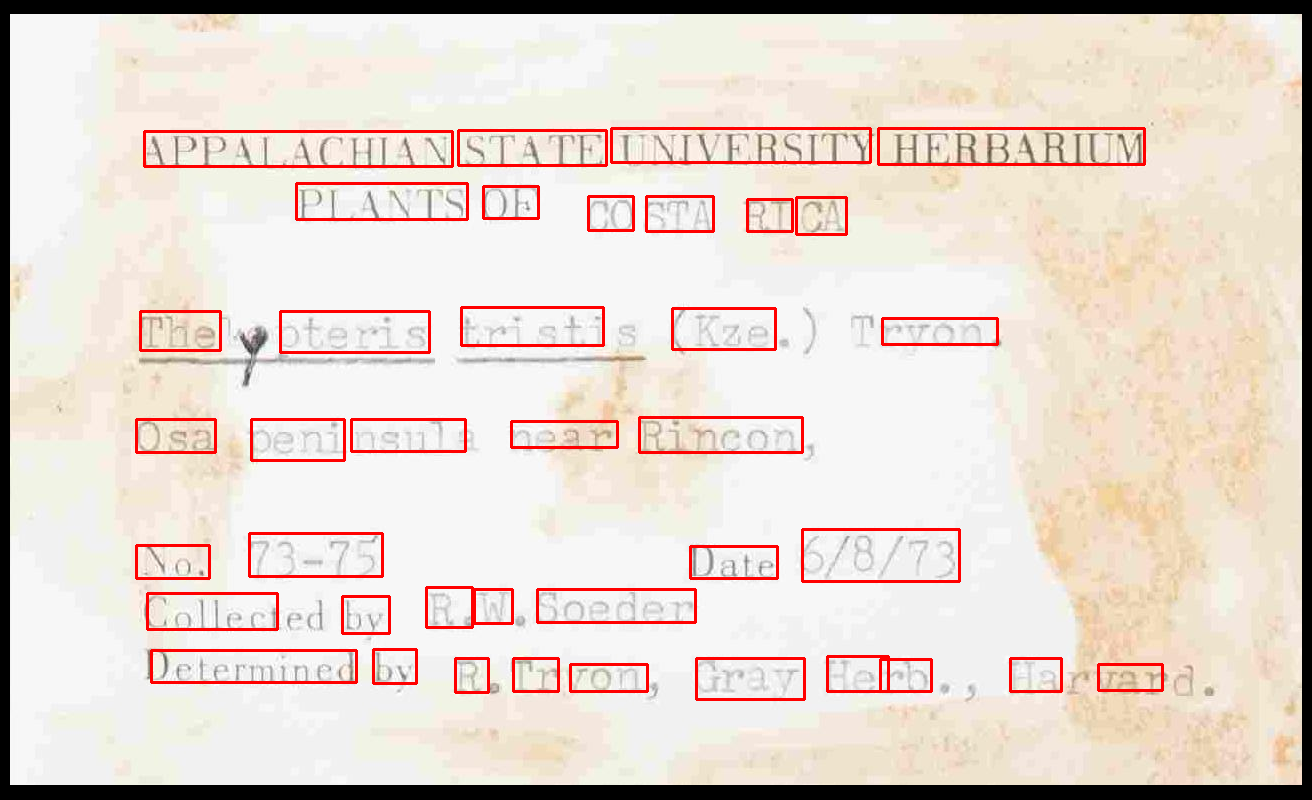

In [20]:
temp = cv.cvtColor(image, cv.COLOR_BGR2RGB)
display(PImage.fromarray(temp))